In [421]:
import pandas as pd
import pickle
from sklearn.neighbors import NearestNeighbors
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})

In [422]:
#load dfs
researchers = pd.read_pickle("Files/Dataframes/researchers.pkl") 
sponsUnitResearchers = pd.read_pickle("Files/Dataframes/researchers_sponsoringUnits.pkl")

#load list with known sponsoring units from APS
with open('Files/knownDivisions.pkl', 'rb') as f:
    divisions = pickle.load(f)

## One-hot encoding

In [423]:
knownUnits = list(set(divisions).intersection(set(sponsUnitResearchers.AssignedSponsoringUnit.unique())))

In [424]:
#all sponsoring units in list, aggregate when it is same SearchName, Year and SessionType
#keep Seniority, CumulativePaperCount and Productivity as well
researchers_allSponUnit = sponsUnitResearchers.groupby(['SearchName', 'Year', 'SessionType'], as_index=False).agg({'AssignedSponsoringUnit': list, 'Seniority': 'first', 'CumulativePaperCount': 'first', 'Productivity': 'first', 'Gender': 'first'}).rename(columns = {'AssignedSponsoringUnit': 'AllSponsoringUnits'})

In [425]:
#one-hot encoding
mlb = MultiLabelBinarizer(sparse_output=True)

oneHot = researchers_allSponUnit.join(pd.DataFrame.sparse.from_spmatrix(
    mlb.fit_transform(researchers_allSponUnit.pop('AllSponsoringUnits')),
    index = researchers_allSponUnit.index, 
    columns = mlb.classes_))

In [426]:
#Select columns
cols = list(researchers_allSponUnit.columns)
cols += knownUnits 

In [427]:
#df with researcher with one-hot encoded sponsoring units
oneHot_researchers = oneHot[cols]

Attendees: potentially invited speakers

Find researchers similar to invited speakers.

use also field

try different distance measures

only compare researchers for same year, but do it for all years. Do it inside algorithm.

## Functions

In [428]:
#def findThreshold(distance, quantile): 
#    threshold = np.quantile(distance, quantile)
#    distance_df = pd.DataFrame(distance, columns = ['Distance'])
    
#    return threshold, distance_df

In [429]:
def standardizeColumn(df, columnName):
    standardizedColumn = (df[columnName] - df[columnName].mean())/(df[columnName].std())
    
    return standardizedColumn

In [463]:
def plotYearlyDistances(distance, threshold, year):
    df = pd.DataFrame(distance.flatten(), columns = ['Distance'])
    
    fig, ax = plt.subplots(1,1)
    sns.histplot(df, x = 'Distance', stat = 'proportion')
    plt.axvline(x = threshold, color = 'black', linewidth = 1, label = '0.5 quantile: ' + str("{:.2f}".format(threshold))).set_linestyle("--")
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Distance to five nearest neighbors in ' + str(year))
    plt.tight_layout()
    plt.show()
    #plt.box(False)
    

In [541]:
def likelihood(indices, df1, df2): #df1 is females, df2 is males
    similarResearchers_df = pd.DataFrame(data = df2['SessionType'])
    index_rand = [np.random.choice(i, 1)[0] for i in indices] #randomly select index for each row
    similarResearchers_df['SimilarFemaleIndex'] = index_rand #create column with the random similar female indices
    similarResearchers_df = similarResearchers_df.dropna(subset = 'SimilarFemaleIndex') #drop rows where the researchers are not similar enough
    #similarIndex = similarResearchers.SimilarFemaleIndex
    similarFemales = df1.iloc[similarResearchers_df.SimilarFemaleIndex][['SessionType']] #the random selected similar females
    similarResearchers = pd.merge(similarResearchers_df, similarFemales, left_on = 'SimilarFemaleIndex', right_on = similarFemales.index, how = 'inner', suffixes=("_M", "_F"))
    
    #calculate likelihood
    maleInvited = similarResearchers.SessionType_M.value_counts(normalize = True).loc['invited']
    femaleInvited = similarResearchers.SessionType_F.value_counts(normalize = True).loc['invited']
    
    likelihood_n = maleInvited/femaleInvited
    
    return likelihood_n

In [544]:
def KNN(df, standardizeFeatures, groupFeature, groups, allFeatures, K, q, N): 
    #KNN_dict = {}
    likelihood_dict = {}
    index = 0
    KNN_researchers = df.copy()
    for c in standardizeFeatures:
        KNN_researchers[c] = standardizeColumn(KNN_researchers, c) #standardize data
    
    yearList = np.sort(KNN_researchers.Year.unique())
    for y in tqdm(yearList):
        year_df = KNN_researchers[KNN_researchers.Year == y] #get all data from year y
        group1 = year_df[year_df[groupFeature] == groups[0]].reset_index(drop = True)
        group2 = year_df[year_df[groupFeature] == groups[1]].reset_index(drop = True)
        
        neighbors = NearestNeighbors(n_neighbors=K).fit(group1[allFeatures].to_numpy())
        kNeighbor_dist, kNeighbor_ind = neighbors.kneighbors(group2[allFeatures].to_numpy()) 
        
        threshold = np.quantile(kNeighbor_dist.flatten(), q) #q quantile
        indices = kNeighbor_ind.copy().astype(float) #get indices of five nearest neighbors of all males
        indices[~(kNeighbor_dist <= threshold)] = np.nan #set indices to nan if their distance is higher than the threshold
        
        plotYearlyDistances(kNeighbor_dist, threshold, y) #plot yearly distances
        
        for n in range(0,N):
            lh = likelihood(indices, group1, group2)
            likelihood_dict[index] = {'Year': y, 'Iteration': n, 'Likelihood': lh}
            index += 1
        
    return likelihood_dict

In [545]:
def avgRelativeLikelihood(df): #calculate average relative likelihood per year
    likelihood_dict = {}
    yearList = np.sort(df.Year.unique())
    for y in yearList:
        avg_likelihood = df[df.Year == y].Likelihood.mean()
        std_likelihood = df[df.Year == y].Likelihood.std()
        likelihood_dict[y] = {'Avg_likelihood': avg_likelihood, 'Std_likelihood': std_likelihood}
    return likelihood_dict

#### Algorithm for calcualting likelihoods of females being invited
1. For each male, random select a female of the k similar females
2. Check session type of male and random female
3. Calculate ratio of invited females and ratio of invited males
4. Divide these 2 numbers, which give the relative likelihood of females being invited
5. Repeat step 1-4 *n* times
6. Calculate average and standard deviation of the *n* relative likelihoods (for later plots)
7. Repeat step 1-6 for each year
8. Females are more likely than males to be invited if the results are above 1, and males are more likely than females to be invited if the results are lower than 1. 

In [546]:
allCols = knownUnits
allCols += ['Seniority', 'CumulativePaperCount', 'Productivity']

  0%|                                                    | 0/19 [00:00<?, ?it/s]

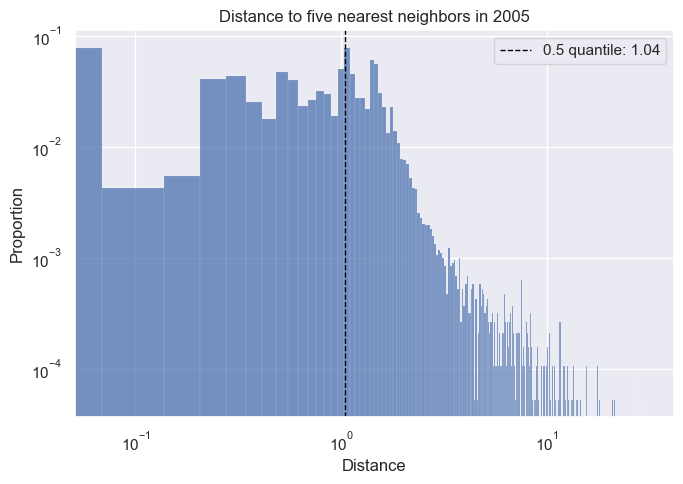

  5%|██▎                                         | 1/19 [00:41<12:23, 41.29s/it]

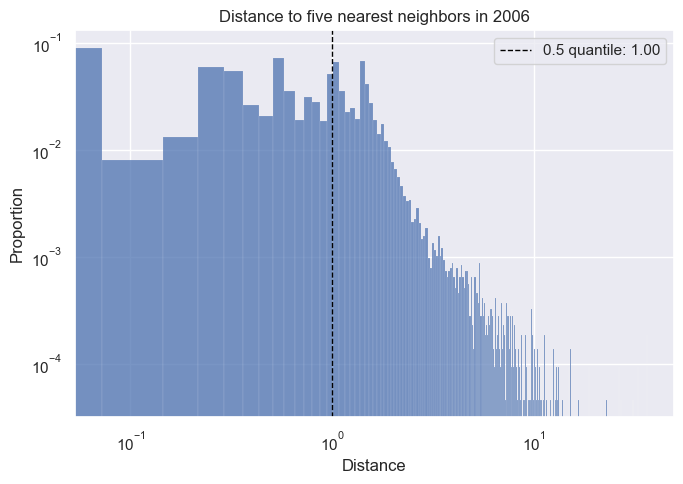

 11%|████▋                                       | 2/19 [01:26<12:20, 43.57s/it]

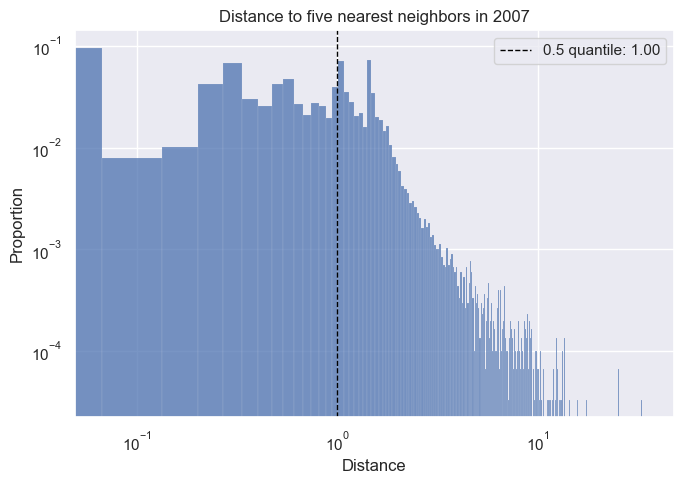

 16%|██████▉                                     | 3/19 [02:32<14:24, 54.01s/it]

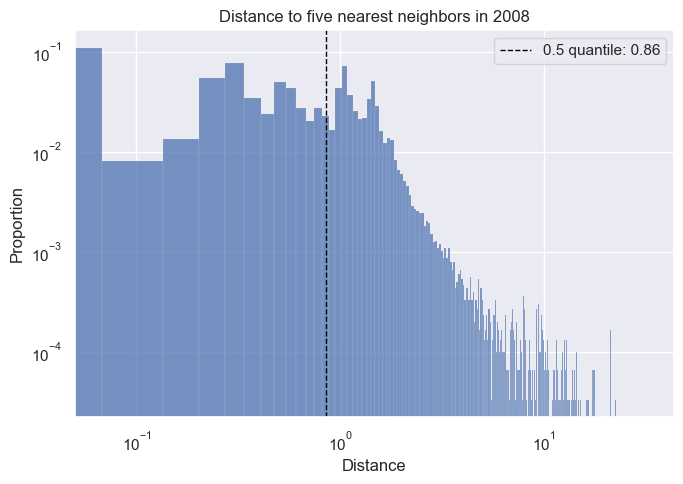

 21%|█████████▎                                  | 4/19 [03:38<14:36, 58.45s/it]

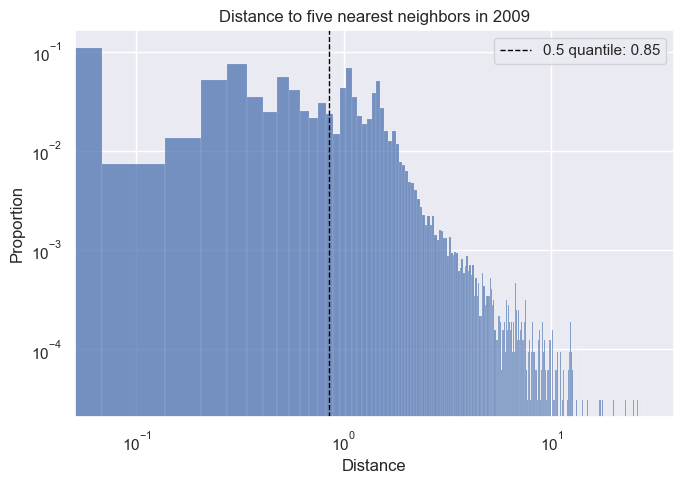

 26%|███████████▌                                | 5/19 [04:42<14:06, 60.49s/it]

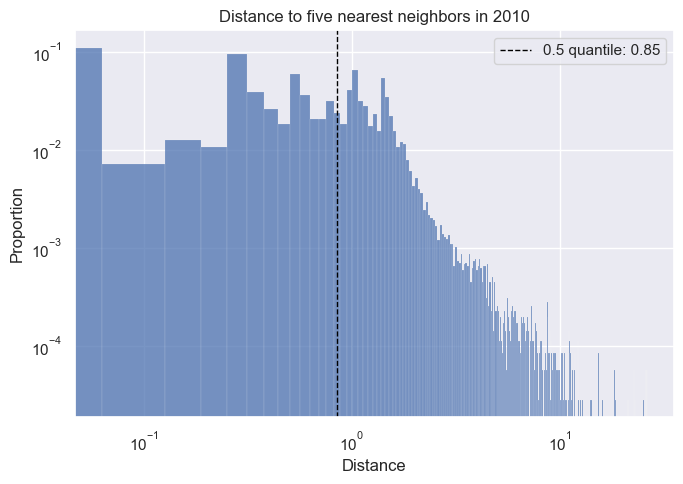

 32%|█████████████▉                              | 6/19 [05:56<14:09, 65.33s/it]

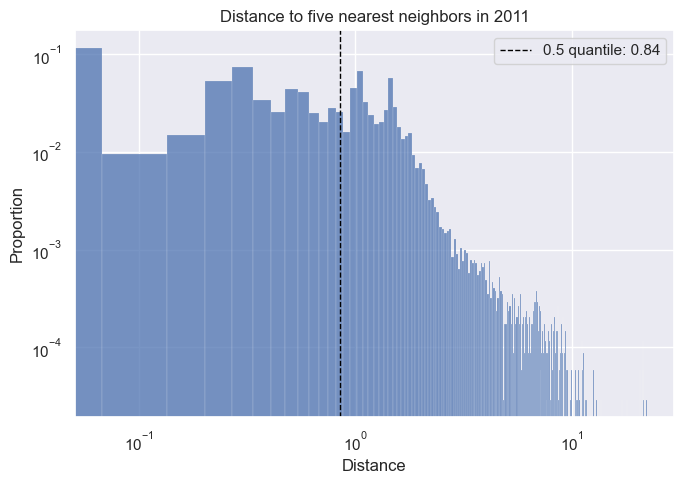

 37%|████████████████▏                           | 7/19 [07:17<14:01, 70.14s/it]

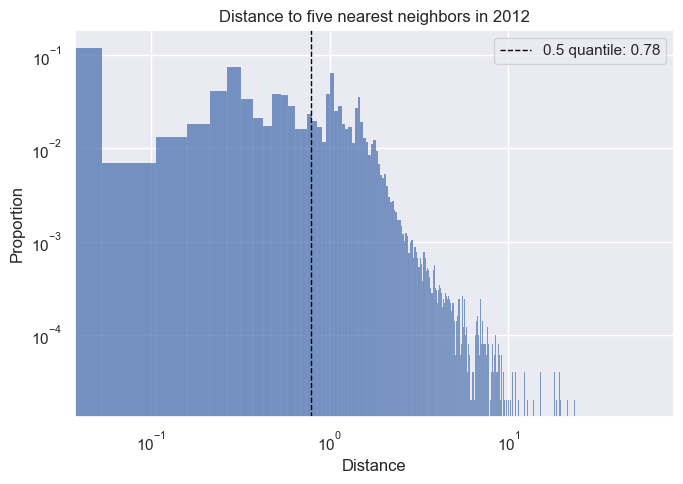

 42%|██████████████████▌                         | 8/19 [09:06<15:08, 82.55s/it]

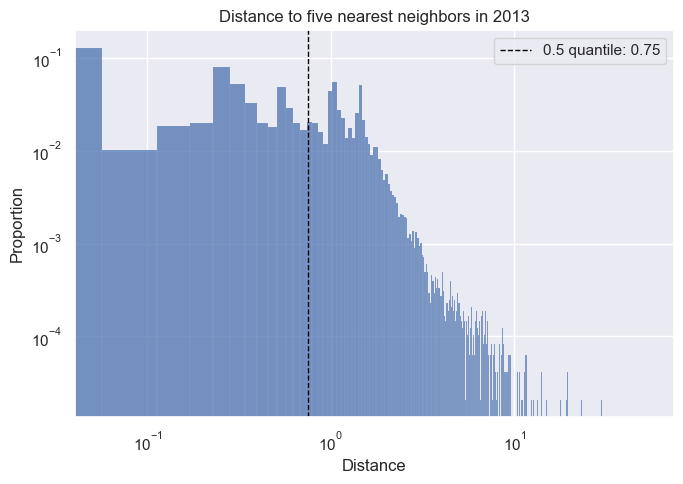

 47%|████████████████████▊                       | 9/19 [10:46<14:42, 88.27s/it]

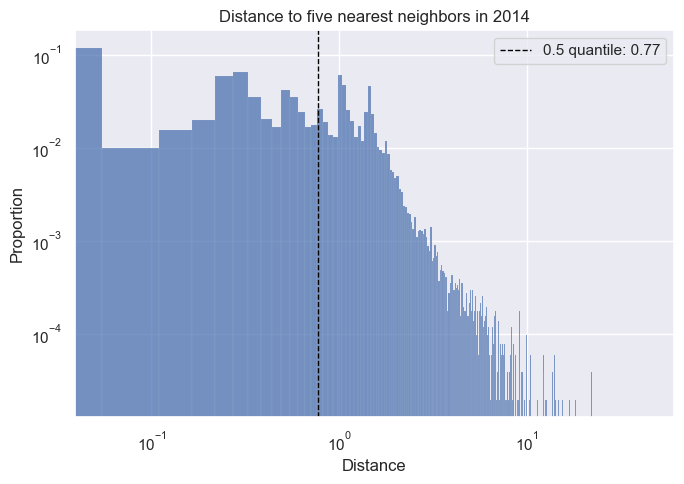

 53%|██████████████████████▋                    | 10/19 [12:32<14:02, 93.62s/it]

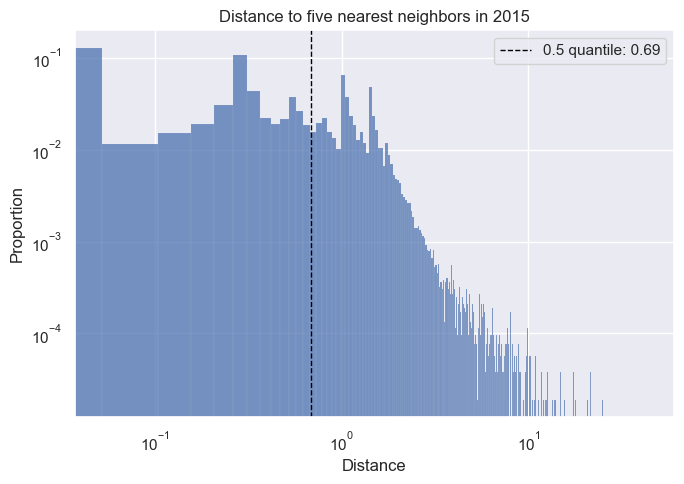

 58%|████████████████████████▉                  | 11/19 [14:24<13:13, 99.13s/it]

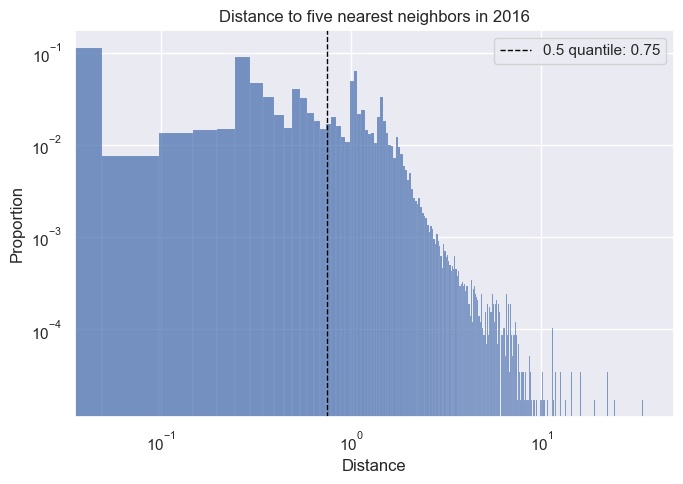

 63%|██████████████████████████▌               | 12/19 [16:27<12:24, 106.40s/it]

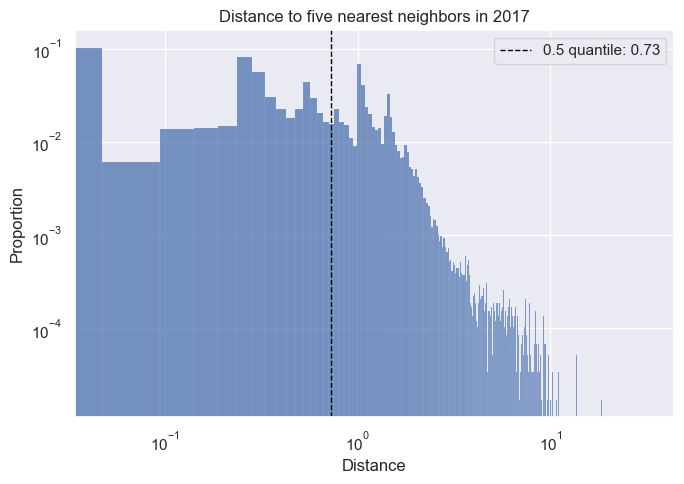

 68%|████████████████████████████▋             | 13/19 [18:27<11:03, 110.61s/it]

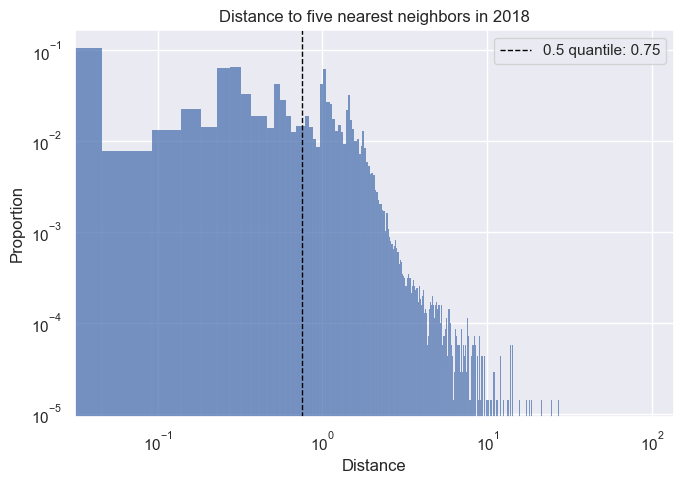

In [ ]:
likelihood_dict = KNN(oneHot_researchers, ['Seniority', 'CumulativePaperCount', 'Productivity'], 'Gender', ['Female', 'Male'], allCols, 5, 0.5, 1000)

In [ ]:
likelihood_df = pd.DataFrame.from_dict(likelihood_dict, orient='index')

In [ ]:
likelihood_stats = pd.DataFrame.from_dict(avgRelativeLikelihood(likelihood_df), orient = 'index')

In [ ]:
likelihood_stats

In [10]:
def KNN(df, standardizeFeatures, allFeatures, K): #K for number of neighbors to find in KNN
    #standardize column and create new df with the standardized attributes
    KNN_dict = {}
    KNN_researchers = df.copy()
    for c in standardizeFeatures:
        KNN_researchers[c] = standardizeColumn(KNN_researchers, c)
    #invitedMales = KNN_researchers[(KNN_researchers.SessionType == 'invited') & (KNN_researchers.Gender == 'Male')]
    invitedSpeakers = KNN_researchers[KNN_researchers.SessionType == 'invited'] #invited speakers
    for i in tqdm(invitedSpeakers.index): #loop through index of invited speakers
        currentInvited = invitedSpeakers[invitedSpeakers.index == i] #current invited speaker
        currentInvited_name = currentInvited.SearchName[i]        
        year = currentInvited.Year[i] #find year of current invited speaker
        yearResearchers = KNN_researchers[KNN_researchers.Year == year]#find researchers within "current" year
        other = yearResearchers[yearResearchers.SearchName != currentInvited_name] #remove current researcher
        #KNN
        if K == "all": #when all neighbors should be found
            k = len(other)
        else:
            k = K
        #neighbors = NearestNeighbors(n_neighbors=K).fit(other)
        neighbors = NearestNeighbors(n_neighbors=k).fit(other[allFeatures].to_numpy())
        kNeighbor_dist, kNeighbor_ind = neighbors.kneighbors(currentInvited[allFeatures].to_numpy())
        #kNeighbor_dist, kNeighbor_ind = neighbors.kneighbors(currentInvited[allFeatures].to_numpy())
        neighbor_df = other.iloc[kNeighbor_ind[0]] #k nearest neighbors as df
        
        KNN_dict[i] = {'Name': currentInvited_name, 'Year': year, 'Gender': currentInvited.Gender.values[0], 'NeighborDistance': kNeighbor_dist[0], 'NeighborNames': list(neighbor_df.SearchName), 'NeighborGender': list(neighbor_df.Gender)}
    return KNN_dict
    #return yearResearchers

In [11]:
#test
#df = oneHot_researchers
#KNN_researchers = df.copy()
#standardizeFeatures = ['Seniority', 'CumulativePaperCount', 'Productivity']
#allFeatures = allCols
#for c in standardizeFeatures:
#    KNN_researchers[c] = standardizeColumn(KNN_researchers, c)
#invitedSpeakers = KNN_researchers[KNN_researchers.SessionType == 'invited'] #invited speakers
#i = 46
#currentInvited = invitedSpeakers[invitedSpeakers.index == i] #current invited speaker
#currentInvited_name = currentInvited.SearchName[i]
#year = currentInvited.Year[i] #find year of current invited speaker
#yearResearchers = KNN_researchers[KNN_researchers.Year == year]#find researchers within "current" year
#other = yearResearchers[yearResearchers.SearchName != currentInvited_name] #remove current researcher
#neighbors = NearestNeighbors(n_neighbors=len(other)).fit(other[allFeatures].to_numpy())
#kNeighbor_dist, kNeighbor_ind = neighbors.kneighbors(currentInvited[allFeatures].to_numpy())
#other.iloc[kNeighbor_ind[0]]
#kNeighbor_dist, kNeighbor_ind

In [12]:
allCols = knownUnits
allCols += ['Seniority', 'CumulativePaperCount', 'Productivity']

In [13]:
KNN_dict = KNN(oneHot_researchers, ['Seniority', 'CumulativePaperCount', 'Productivity'], allCols, "all")

100%|█████████████████████████████████████| 12725/12725 [10:38<00:00, 19.94it/s]


In [14]:
KNN_df = pd.DataFrame.from_dict(KNN_dict, orient='index').explode(['NeighborDistance', 'NeighborNames', 'NeighborGender']).reset_index()

In [18]:
KNN_dfList = pd.DataFrame.from_dict(KNN_dict, orient='index')

In [50]:
distance_df = pd.DataFrame()
distance_df['Year'] = KNN_dfList['Year']

In [51]:
distance_df['Min'] = KNN_dfList.NeighborDistance.apply(lambda x: min(x))
distance_df['Max'] = KNN_dfList.NeighborDistance.apply(lambda x: max(x))

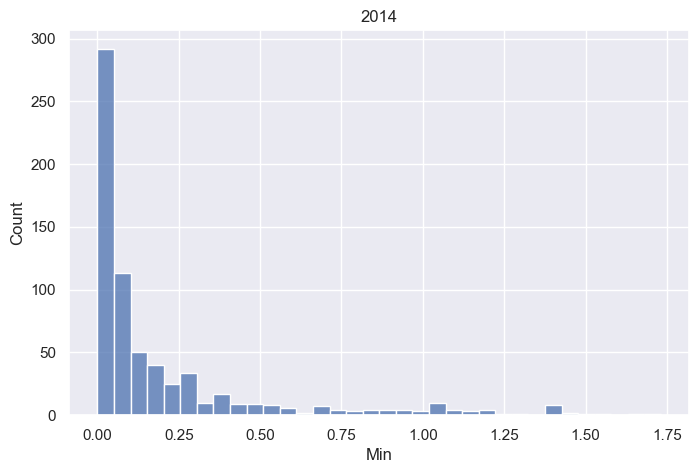

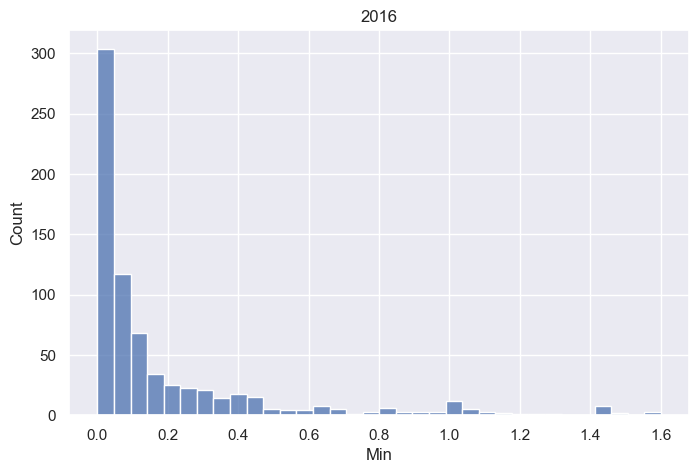

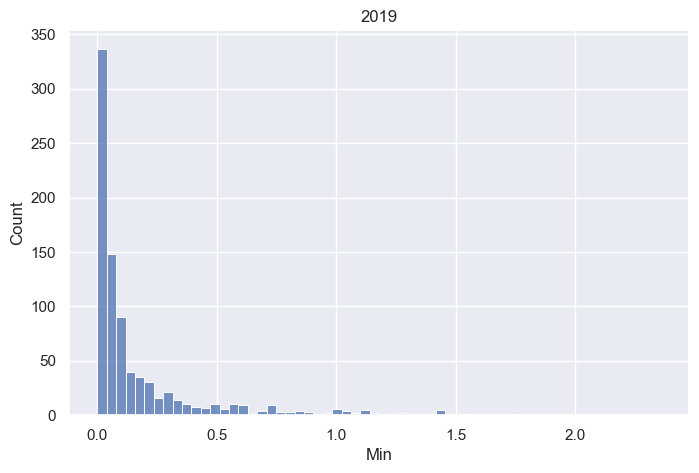

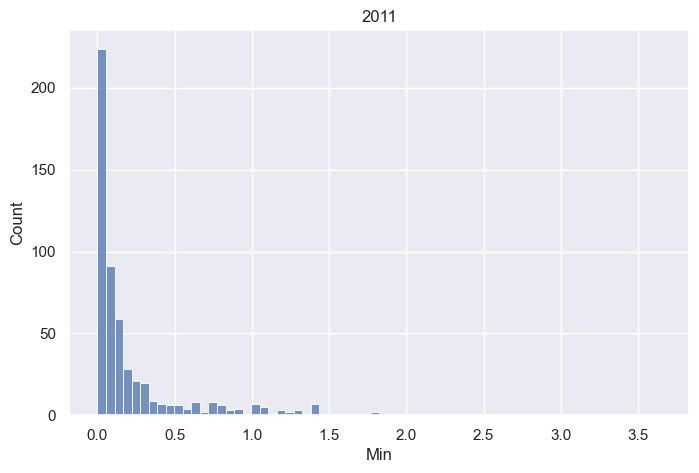

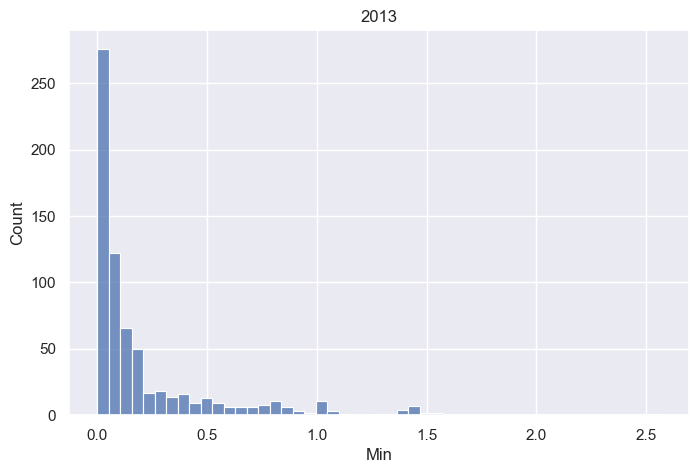

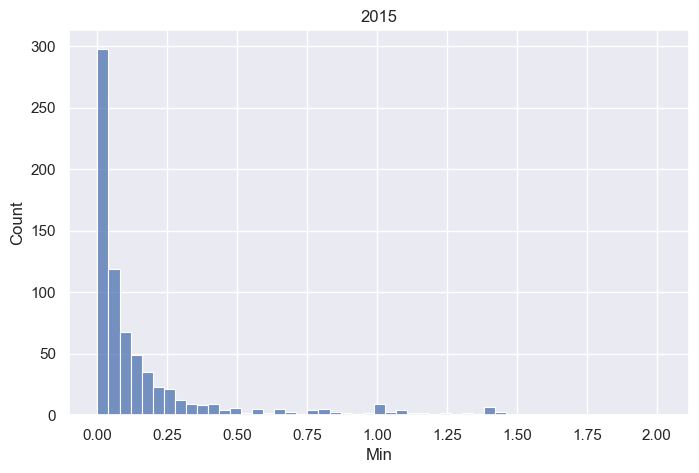

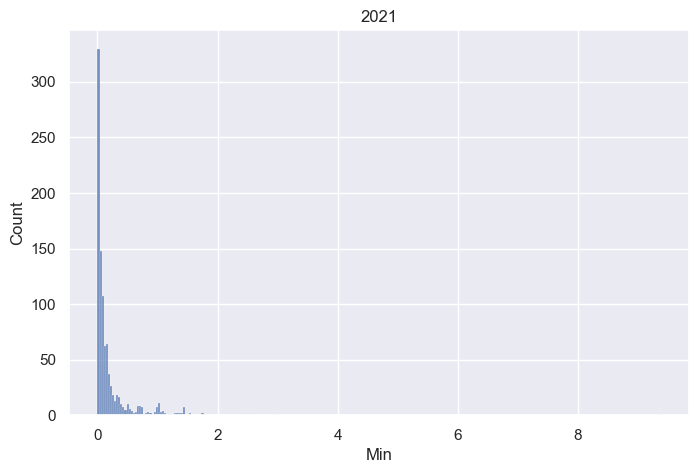

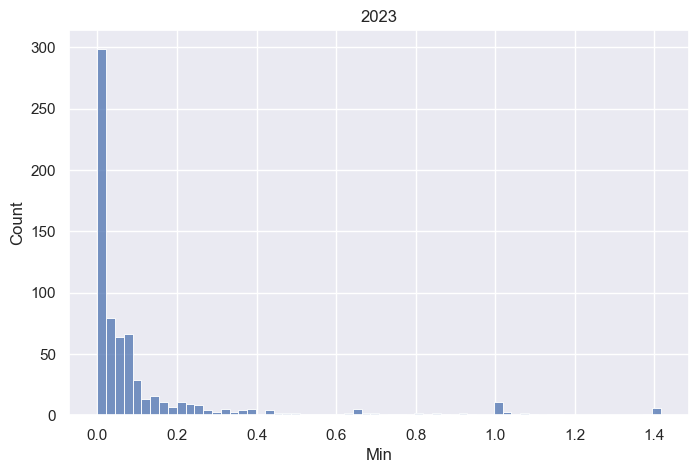

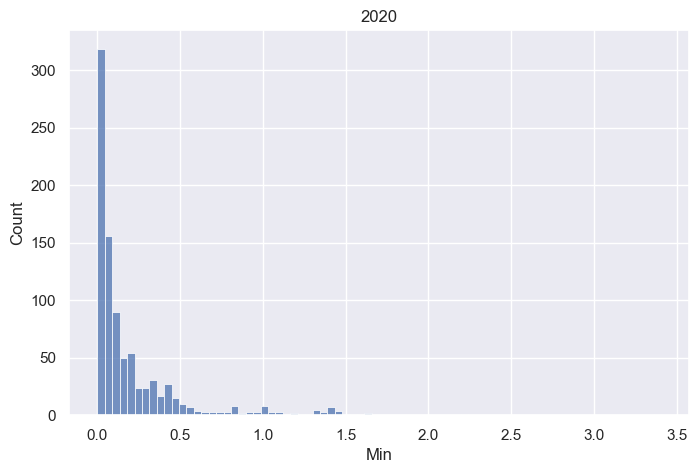

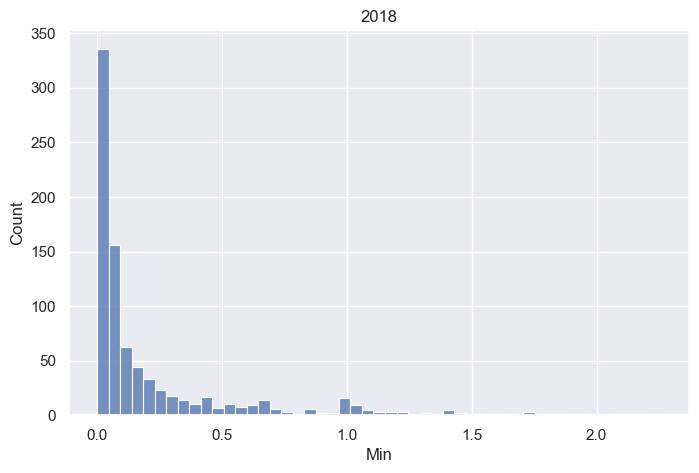

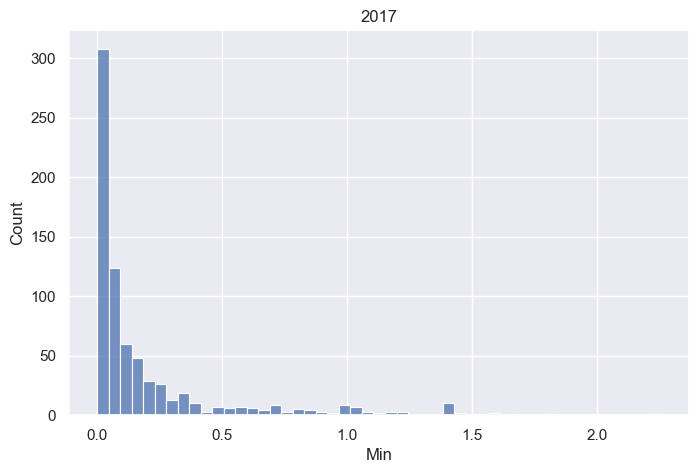

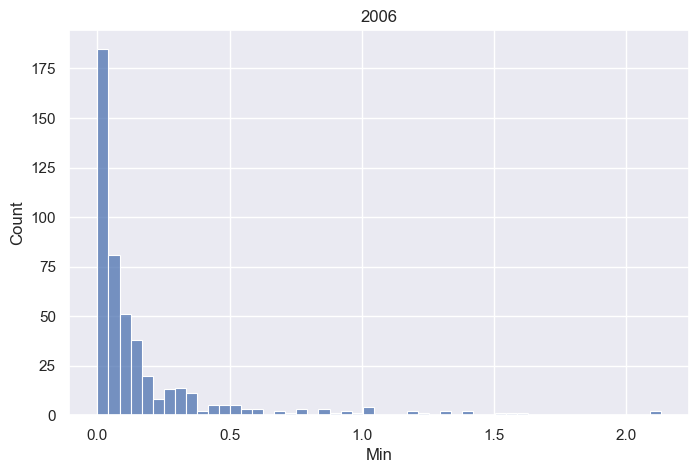

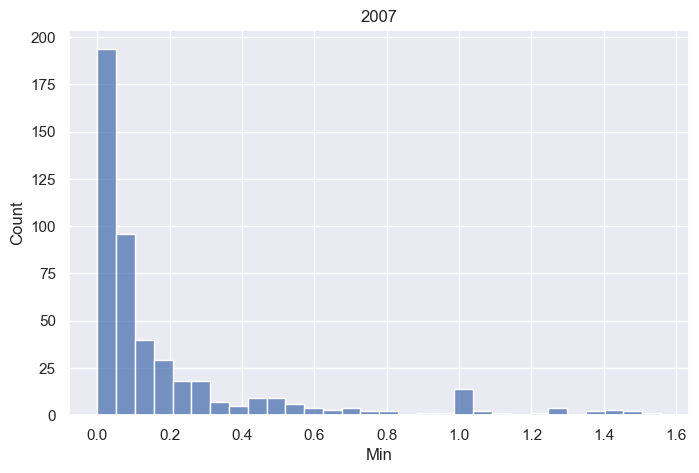

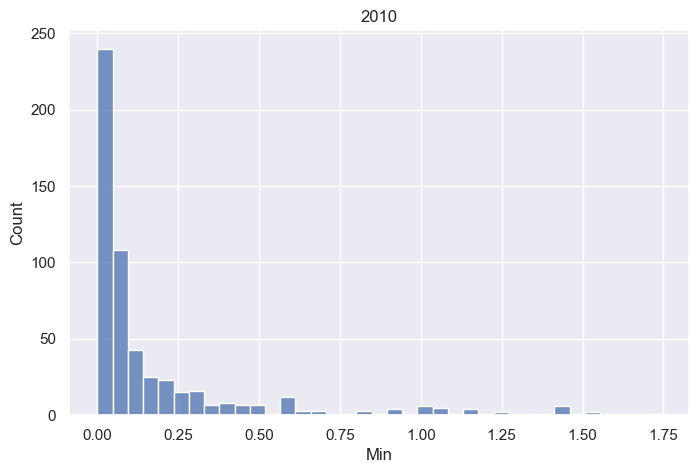

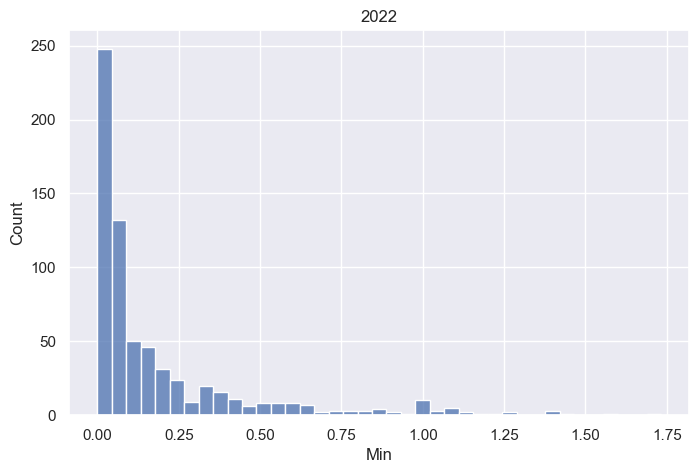

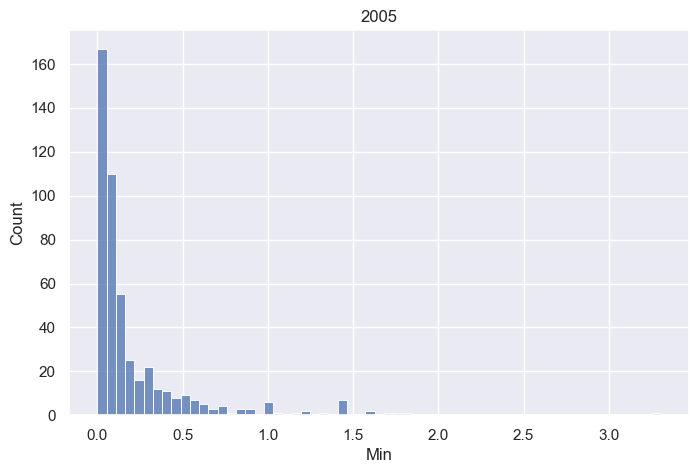

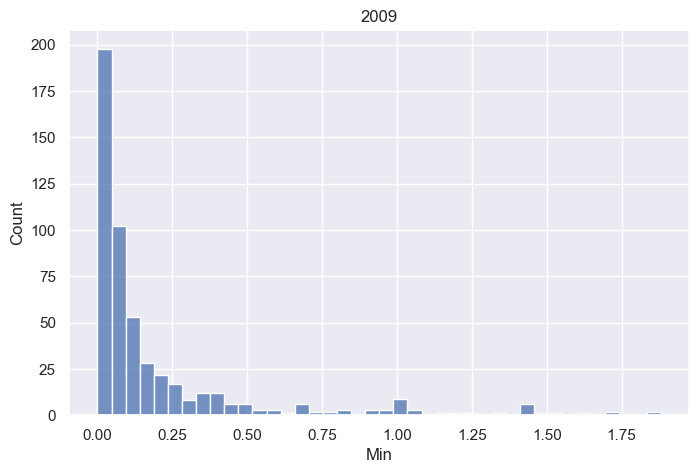

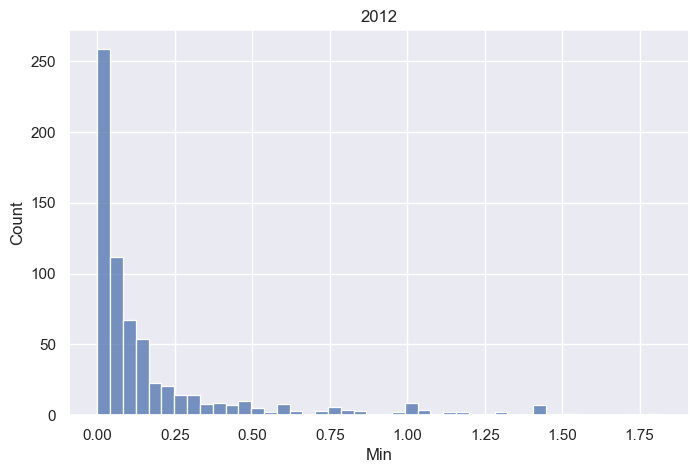

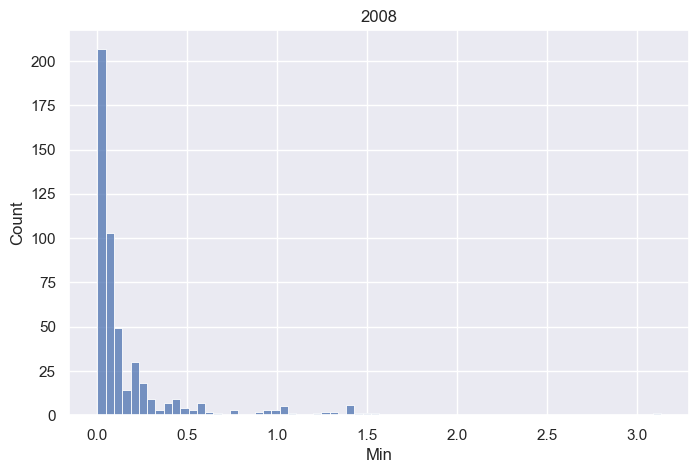

In [89]:
years = distance_df.Year.unique()
for y in years:
    df = distance_df[distance_df.Year == y]
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    plt.title(y)
    sns.histplot(df, x = 'Min')

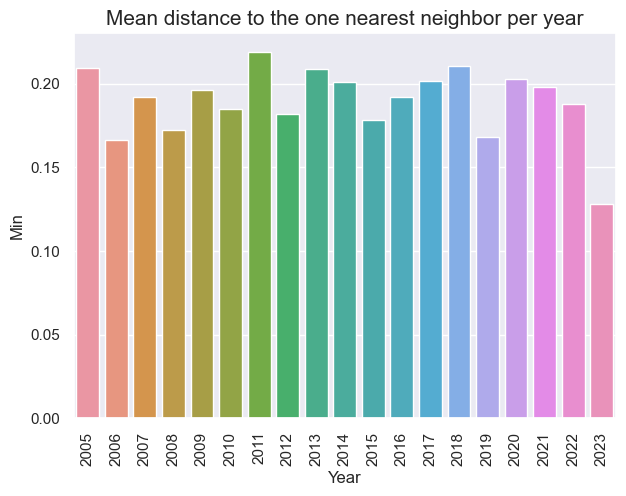

In [69]:
avgTable = distance_df.groupby('Year').mean().reset_index()
sns.barplot(data = avgTable, x = 'Year', y = 'Min')
plt.xticks(rotation=90)
plt.title("Mean distance to the one nearest neighbor per year", fontsize = 15)
plt.show()

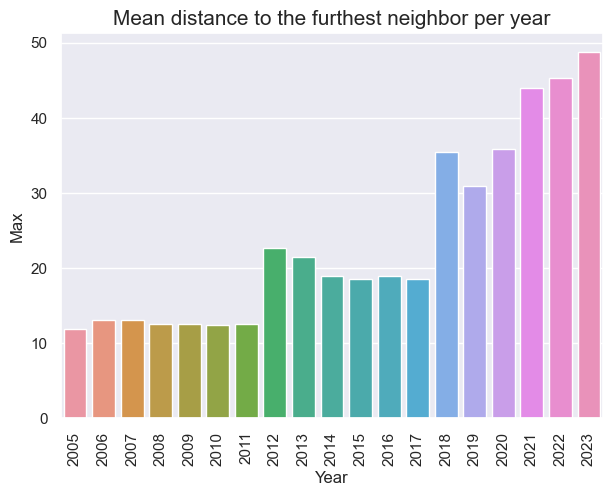

In [70]:
avgTable = distance_df.groupby('Year').mean().reset_index()
sns.barplot(data = avgTable, x = 'Year', y = 'Max')
plt.title("Mean distance to the furthest neighbor per year", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

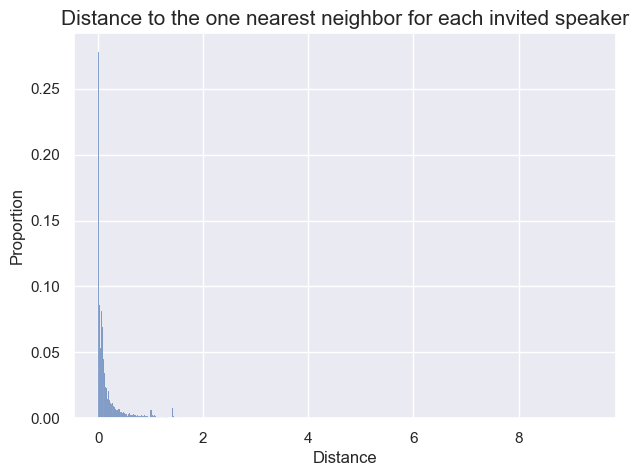

In [56]:
sns.histplot(data = distance_df, x = 'Min', stat = 'proportion')
plt.xlabel('Distance')
plt.title("Distance to the one nearest neighbor for each invited speaker", fontsize = 15)
#plt.savefig("Figures/title", bbox_inches='tight')
plt.show()

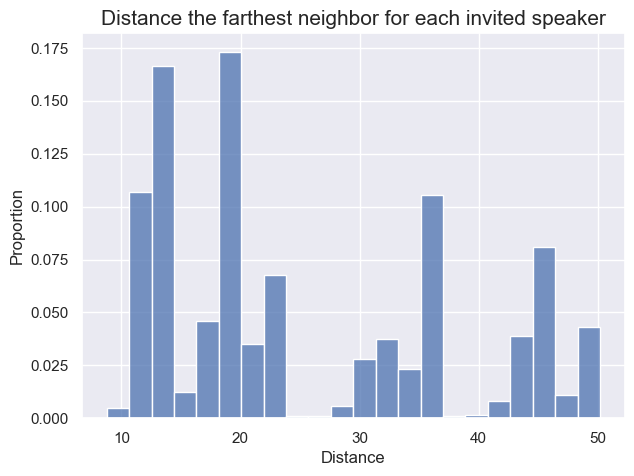

In [55]:
sns.histplot(data = distance_df, x = 'Max', stat = 'proportion')
plt.xlabel('Distance')
plt.title("Distance the farthest neighbor for each invited speaker", fontsize = 15)
#plt.savefig("Figures/title", bbox_inches='tight')
plt.show()

<AxesSubplot:xlabel='NeighborDistance', ylabel='Count'>

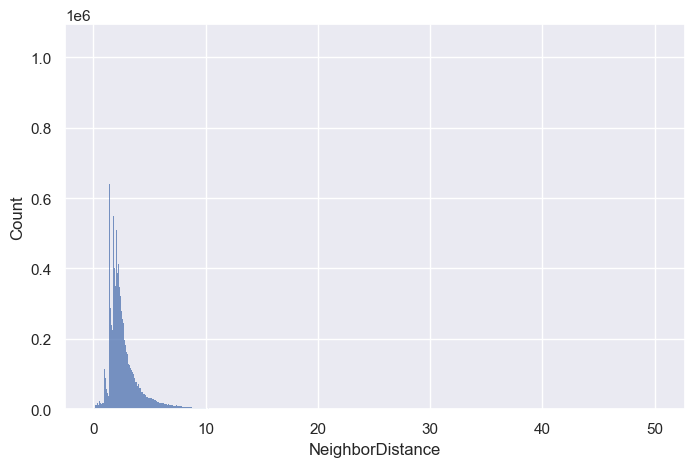

In [90]:
sns.histplot(data = KNN_df, x = 'NeighborDistance')
plt.show()

KeyboardInterrupt: 

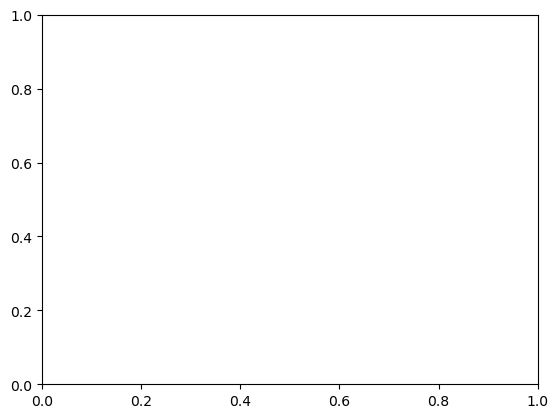

In [20]:
sns.histplot(data = KNN_df, x = 'Neighbor distance', bins = 10)

In [8]:
distance_table = KNN_df.groupby('Neighbor distance').count()

In [9]:
distanceCount = distance_table.reset_index()
distanceCount

,Neighbor distance,Name,Year,Neighbor index
0,0.000000e+00,372339,372339,372339
1,9.313226e-10,7,7,7
2,1.317089e-09,9,9,9
3,1.862645e-09,28,28,28
4,2.634178e-09,73,73,73
...,...,...,...,...
21395540,4.975554e+01,1,1,1
21395541,4.984776e+01,1,1,1
21395542,4.996473e+01,1,1,1
21395543,5.006720e+01,1,1,1


In [19]:
researchers.drop_duplicates(subset = ['Seniority', 'CumulativePaperCount', 'Productivity'])[['Seniority', 'CumulativePaperCount', 'Productivity']].max()

Seniority               218.000000
CumulativePaperCount    500.000000
Productivity            164.666667
dtype: float64

In [21]:
researchers[researchers.Seniority >= 100]

,SearchName,FirstName,ResearcherCount,MaxPaperCount,API_Field,API_FieldCount,ExternalField,ModelField,ExternalFieldCount,ModelFieldCount,...,Title,SponsoringUnit,SessionIndex,SessionType,Seniority,CumulativePaperCount,Productivity,firstName,Gender,AssignedSponsoringUnit
347,felix krueger,felix,12,33,Philosophy,7,Philosophy,History,7,1,...,Inference of emergent spatio-temporal processe...,DBIO,127935.0,attendee,120,19,0.158333,felix,Male,Biological Physics
651,pablo iglesias,pablo,107,6,Engineering,2,Engineering,Engineering,2,1,...,A modular view of directed cell migration,DCMP GSNP,128469.0,invited,120,1,0.008333,pablo,Male,None
855,hisao kanda,hisao,5,210,Materials Science,112,Materials Science,Materials Science,112,193,...,Pressure dependence of the first-order Raman f...,DCMP DMP,11195.0,attendee,100,166,1.660000,hisao,Male,None
1834,crispin contreras-martinez,crispin,2,22,Physics,13,Physics,Physics,13,21,...,Characterization of losses in dielectric subst...,DQI,11247.0,attendee,123,17,0.138211,crispin,Male,Quantum Information
1835,yuriy pischalnikov,yuriy,5,199,Physics,129,Physics,Physics,129,190,...,Characterization of losses in dielectric subst...,DQI,11247.0,attendee,123,189,1.536585,yuriy,Male,Quantum Information
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553732,pascoal pagliuso,pascoal,4,342,Physics,170,Physics,Physics,170,330,...,Structural and Physical Properties of CeAu2Bi:...,DCMP,135588.0,attendee,119,299,2.512605,pascoal,Male,Condensed Matter Physics
553733,pascoal pagliuso,pascoal,4,342,Physics,170,Physics,Physics,170,330,...,The Role of the Relaxation Rate of Nematic Flu...,DMP,142351.0,attendee,118,286,2.423729,pascoal,Male,Materials Physics
553735,pascoal pagliuso,pascoal,4,342,Physics,170,Physics,Physics,170,330,...,Complex magnetism in novel intermetallic compo...,DCMP,170995.0,attendee,123,336,2.731707,pascoal,Male,Condensed Matter Physics
553934,james martin,james,1275,3,Medicine,2,Medicine,Medicine,2,3,...,Dynamics of particle suspensions subjected to ...,DCMP,80671.0,invited,109,3,0.027523,james,Male,Condensed Matter Physics


In [ ]:
sns.barplot(data = distanceCount, x = 'Neighbor distance', y = 'Name')

In [ ]:
#now plot the distances from KNN_dict.
#Find a way to also check for individual distances. How much do they vary(variance)?
#Find a way to check for differences in differen years. Maybe a histogram for each year, or do year as hue

In [92]:
neighbors = NearestNeighbors(n_neighbors=10, metric = 'euclidean')
neighbors.fit(data)

knn = neighbors.kneighbors(researcher.reshape(1, -1))

NameError: name 'data' is not defined

In [91]:
test_df[['Seniority', 'CumulativePaperCount', 'Productivity']]

,Seniority,CumulativePaperCount,Productivity
2,2,2,1.000000
8,16,4,0.250000
111,43,104,2.418605
262,6,4,0.666667
264,2,1,0.500000
...,...,...,...
553878,25,15,0.600000
553921,37,20,0.540541
554146,15,46,3.066667
554174,7,3,0.428571


In [105]:
data = KNN_researchers[['Seniority', 'CumulativePaperCount', 'Productivity']]
researcher = KNN_researchers[KNN_researchers.SessionType == 'invited'][['Seniority', 'CumulativePaperCount', 'Productivity']].iloc[0].to_numpy().reshape(1, -1)

In [128]:
neighbors = NearestNeighbors(n_neighbors=10, metric = 'manhattan')
neighbors.fit(data)

NearestNeighbors(metric='manhattan', n_neighbors=10)

In [129]:
knn = neighbors.kneighbors(researcher.reshape(1, -1))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [130]:
knn

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[3406, 3583, 2282, 3576, 3464, 3473,    2,  135,  305,   52]]))

In [131]:
researcher

array([[-0.88210549, -0.51229433, -0.3393391 ]])

In [109]:
KNN_researchers.iloc[3406]

SearchName                                                         steve barr
FirstName                                                               steve
ResearcherCount                                                            11
MaxPaperCount                                                               2
API_Field                                               Environmental Science
API_FieldCount                                                              1
ExternalField                                           Environmental Science
ModelField                                              Environmental Science
ExternalFieldCount                                                          1
ModelFieldCount                                                             2
FirstPaperYear                                                           2008
Year                                                                     2010
Name                                                            

NearestNeighbors(n_neighbors=10)

In [80]:
knn = NearestNeighbors(n_neighbors=10, algorithm='auto')
knn.fit(KNN_researchers[['Seniority', 'CumulativePaperCount', 'Productivity']].to_numpy())

NearestNeighbors(n_neighbors=10)

In [ ]:
##do knn with one invited male speaker(for one year)


X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
>>> nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
>>> distances, indices = nbrs.kneighbors(X)